# Step 2-2 Univariate DL Models



In [112]:
# Necessary imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.arima.model import ARIMA

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, Conv1D, Flatten
from tensorflow.keras.layers import RepeatVector, TimeDistributed, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

import warnings
import os

warnings.filterwarnings("ignore")

In [113]:
# Config
TARGET_VARIABLES = 'co2'
SELECTED_COUNTRIES = ['United States', 'China', 'India']
MAX_LAGS = 4
N_STEPS_IN = 5
N_STEPS_OUT = 1
TEST_SIZE = 9
save_dir = 'data/02_02_results'
os.makedirs(save_dir, exist_ok=True)

ARIMA_ORDERS = {
    'United States': (0, 1, 0),
    'China': (0, 2, 0),
    'India': (1, 1, 1)
}

In [114]:
DL_CONFIGS = {
    'LSTM': [
        {'hidden': 16, 'epochs': 100},
        {'hidden': 32, 'epochs': 100}
    ],
    'Bi-LSTM': [
        {'hidden': 8, 'epochs': 100},
        {'hidden': 16, 'epochs': 100}
    ],
    'ED-LSTM': [
        {'hidden': 8, 'epochs': 100},
        {'hidden': 16, 'epochs': 100}
    ],
    'CNN': [
        {'filters': 16, 'epochs': 100},
        {'filters': 32, 'epochs': 100}
    ]
}

In [115]:
def load_data(save_dir='data'):
    data_files = {
        'all_data_df': os.path.join(save_dir, 'all_data_df.csv'),
        'g20_lag_df': os.path.join(save_dir, 'g20_lag_df.csv'),
        'lag_three_sel_1969_df': os.path.join(save_dir, 'lag_three_sel_1969_df.csv')
    }

    dfs = {}
    for name, filepath in data_files.items():
        if os.path.exists(filepath):
            dfs[name] = pd.read_csv(filepath)
            print(f"Loaded {name}: {dfs[name].shape}")
        else:
            print(f"{filepath} not found")
    
    return dfs

In [116]:
data = load_data()
all_data_df = data['all_data_df']
g20_lag_df = data['g20_lag_df']
g20_lag_1969_df = g20_lag_df[g20_lag_df['year'] >= 1969].copy()
g20_lag_1969_df = g20_lag_1969_df[g20_lag_1969_df['year'] < 2023]
lag_three_sel_1969_df = data['lag_three_sel_1969_df']

Loaded all_data_df: (55529, 200)
Loaded g20_lag_df: (3744, 992)
Loaded lag_three_sel_1969_df: (162, 992)


In [117]:
# train_test_split
def tts_by_year(df, test_size=9):
    train_data = {}
    test_data = {}

    for country in df['country'].unique():
        country_data = df[df['country'] == country].sort_values('year')

        split_idx = len(country_data) - test_size
        train_data[country] = country_data.iloc[:split_idx]
        test_data[country] = country_data.iloc[split_idx:]

    train_df = pd.concat(train_data.values(), ignore_index=True)
    test_df = pd.concat(test_data.values(), ignore_index=True)

    return train_df, test_df

In [118]:
train_3_df, test_3_df = tts_by_year(lag_three_sel_1969_df, TEST_SIZE)
train_g20_df, test_g20_df = tts_by_year(g20_lag_1969_df, TEST_SIZE)

### Miscellaneous

In [119]:
def mase(y_actual, y_pred, period=1):
    mae_forecast = mean_absolute_error(y_actual, y_pred)

    naive_forecast = y_actual[:-period] if period > 0 else y_actual[:-1]
    actual_for_naive = y_actual[period:] if period > 0 else y_actual[1:]

    if len(naive_forecast) == 0:
        return np.nan
    
    mae_naive = mean_absolute_error(actual_for_naive, naive_forecast)

    if mae_naive == 0:
        return 0 if mae_forecast == 0 else np.inf
    
    return mae_forecast / mae_naive

In [120]:
def calculate_pct_change(df, features, max_lags=MAX_LAGS):
    df_copy = df.copy()
    df_copy = df_copy.sort_values(['country', 'year']).reset_index(drop=True)
    pct_change_cols = []

    for feature in features:
        if feature not in df_copy.columns:
            continue

        # Pct change on current values
        lag1_col = f"{feature}_lag1"
        if lag1_col in df_copy.columns:
            df_copy[f"{feature}_pct_change"] = ((df_copy[feature] - df_copy[lag1_col]) / df_copy[lag1_col] * 100)
            pct_change_cols.append(f"{feature}_pct_change")

        # Pct change on lagged values
        for lag in range(1, max_lags):
            lag_col = f"{feature}_lag{lag}"
            prev_lag_col = f"{feature}_lag{lag+1}"
            
            if lag_col in df_copy.columns and prev_lag_col in df_copy.columns:
                df_copy[f"{lag_col}_pct_change"] = ((df_copy[lag_col] - df_copy[prev_lag_col]) / df_copy[prev_lag_col] * 100)
                pct_change_cols.append(f"{lag_col}_pct_change")

        # Lag4 for the first row = 0, then shift lag3_pct by country
        last_lag_col = f"{feature}_lag{max_lags}"
        lag3_pct_col = f"{feature}_lag{max_lags-1}_pct_change"

        if last_lag_col in df_copy.columns and lag3_pct_col in df_copy.columns:
            df_copy[f"{last_lag_col}_pct_change"] = df_copy.groupby('country')[lag3_pct_col].shift(1).fillna(0)
            pct_change_cols.append(f"{last_lag_col}_pct_change")
            
        df_copy = df_copy.replace([np.inf, -np.inf], np.nan)
    
    return df_copy, pct_change_cols

In [121]:
def create_sequences(data, n_steps_in):
    X, y = [], []

    for i in range(len(data) - n_steps_in):
        X.append(data[i:i + n_steps_in])
        y.append(data[i + n_steps_in])
        
    return np.array(X), np.array(y)

### DL Model Builds

In [122]:
def build_lstm(input_shape, hidden=16):
    model = Sequential([
        LSTM(hidden, activation='relu', input_shape=input_shape, kernel_regularizer=l2(0.01)),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

    return model

In [123]:
def build_bilstm(input_shape, hidden=8):
    model = Sequential([
        Bidirectional(LSTM(hidden, activation='relu', kernel_regularizer=l2(0.001), recurrent_regularizer=l2(0.01)),
                      input_shape=input_shape),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

    return model

In [124]:
def build_edlstm(input_shape, hidden=8):
    model = Sequential([
        LSTM(hidden, activation='relu', input_shape=input_shape, kernel_regularizer=l2(0.01)),
        RepeatVector(N_STEPS_OUT),
        LSTM(hidden, activation='relu', return_sequences=True, kernel_regularizer=l2(0.01)),
        TimeDistributed(Dense(1))
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

    return model

In [125]:
def build_cnn(input_shape, filters=16):
    model = Sequential([
        Conv1D(filters=filters, kernel_size=2, activation='relu', input_shape=input_shape, padding='same', kernel_regularizer=l2(0.01)),
        Flatten(),
        Dense(8, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    
    return model

### DL Model Train and Forecast

In [126]:
def train_dl(train_df, test_df, target, selected_countries):
    # Applying pct_change to train
    all_train_pct_data = []
    country_train_info = {}

    for country in train_df['country'].unique():
        country_data = train_df[train_df['country'] == country].sort_values('year').reset_index(drop=True)

        country_pct, _ = calculate_pct_change(country_data, [target], MAX_LAGS)
        pct_col = f"{target}_pct_change"
        pct_values = country_pct[pct_col].fillna(0).values

        all_train_pct_data.extend(pct_values)

        country_train_info[country] = {
            'pct_values': pct_values,
            'original_values': country_data[target].values,
            'years': country_data['year'].values
        }
    
    # Fit one scaler all countires' combined train
    all_train_pct_array = np.array(all_train_pct_data).reshape(-1, 1)
    scaler = StandardScaler()
    scaler.fit(all_train_pct_array)
    print(f"Applied StandardScaler: mean={scaler.mean_[0]:.4f}, std={np.sqrt(scaler.var_[0]):.4f}")

    # Sequences for all countries
    X_train_all = []
    y_train_all = []

    for country in train_df['country'].unique():
        pct_values = country_train_info[country]['pct_values']
        scaled_values = scaler.transform(pct_values.reshape(-1, 1)).ravel()
        X_country, y_country = create_sequences(scaled_values, N_STEPS_IN)
        X_train_all.append(X_country)
        y_train_all.append(y_country)

    X_train = np.vstack(X_train_all)
    y_train = np.concatenate(y_train_all)
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    print(f"Training Sequence: X_train shape = {X_train.shape}, y_train shape = {y_train.shape}")

    # Train models on combined data 
    dl_models = {
          'LSTM': build_lstm,
          'Bi-LSTM': build_bilstm,
          'ED-LSTM': build_edlstm,
          'CNN': build_cnn
      }
    
    trained_models = {}

    for model_name, model_func in dl_models.items():
        print(f"    Training {model_name}\n")
        best_val_loss = np.inf
        best_model = None
        best_config = None

        for config in DL_CONFIGS[model_name]:
            epochs = config['epochs']
            config_params = {k: v for k, v in config.items() if k != 'epochs'}

            input_shape = (X_train.shape[1], X_train.shape[2])
            if model_name == 'CNN':
                model = model_func(input_shape, filters=config_params['filters'])
            else:
                model = model_func(input_shape, hidden=config_params['hidden'])
           
            history = model.fit(
                X_train, y_train,
                epochs=epochs,
                batch_size=16,
                validation_split=0.1,
                verbose=0
            )

            val_loss = history.history['val_loss'][-1]
            print(f"    {config}: val_loss {val_loss:.6f}")

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_model = model
                best_config = config
            else:
                tf.keras.backend.clear_session()
                del model
            
        trained_models[model_name] = {
            'model': best_model,
            'config': best_config
        }
        
        print(f"\nBest {model_name} config: {best_config} (val_loss: {best_val_loss:.6f})")

    # Evaluation on each country separately
    all_results = {}
    
    for country in selected_countries:
        print(f"\nEvaluating: {country.upper()}")

        train_country = train_df[train_df['country'] == country].sort_values('year').reset_index(drop=True)
        test_country = test_df[test_df['country'] == country].sort_values('year').reset_index(drop=True)
        
        combined_data = pd.concat([train_country, test_country], ignore_index=True)
        
        combined_pct, _ = calculate_pct_change(combined_data, [target], MAX_LAGS)
        pct_col = f"{target}_pct_change"
        combined_pct_values = combined_pct[pct_col].fillna(0).values
        
        combined_scaled = scaler.transform(combined_pct_values.reshape(-1, 1)).ravel()
        original_values = combined_data[target].values
        
        X_all, y_all = create_sequences(combined_scaled, N_STEPS_IN)
        
        X_test = X_all[-TEST_SIZE:]
        X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

        test_years = test_country['year'].values
        
        country_results = {}
        
        for model_name in dl_models.keys():
            model = trained_models[model_name]['model']
            config = trained_models[model_name]['config']
            
            preds_scaled = model.predict(X_test, verbose=0)
            
            if len(preds_scaled.shape) == 3:
                preds_scaled = preds_scaled[:, 0, 0]
            else:
                preds_scaled = preds_scaled.ravel()
            
            preds_pct = scaler.inverse_transform(preds_scaled.reshape(-1, 1)).ravel()
            
            forecast = []
            test_start_idx = len(original_values) - TEST_SIZE
            
            for i in range(TEST_SIZE):
                prev_value = original_values[test_start_idx + i - 1]
                predicted_value = prev_value * (1 + preds_pct[i] / 100)
                forecast.append(predicted_value)
            
            forecast = np.array(forecast)
            actual_test = original_values[-TEST_SIZE:]

            # Calculate individual step errors
            individual_errors = np.abs(actual_test - forecast)
            
            rmse_score = np.sqrt(mean_squared_error(actual_test, forecast))
            mase_score = mase(actual_test, forecast)
            
            country_results[model_name] = {
                'forecast': forecast,
                'actual': actual_test,
                'individual_errors': individual_errors,
                'test_years': test_years,
                'RMSE': rmse_score,
                'MASE': mase_score,
                'best_config': config
            }
            
            print(f"    {model_name} - RMSE: {rmse_score:.4f}, MASE: {mase_score:.4f}, Config: {config}")

            # Indiviual step errors
            for i in range(TEST_SIZE):
                print(f"Errors for each year step (abs of diff)")
                print(f"    {test_years[i]}: {individual_errors[i]:.4f}")
        
        all_results[country] = country_results
    
    return all_results, trained_models

### ARIMA for comparison

In [127]:
def train_arima(train_country, test_country, target, order):
    train_sorted = train_country.sort_values('year')
    test_sorted = test_country.sort_values('year')
    
    combined_data = pd.concat([train_sorted, test_sorted], ignore_index=True)
    combined_values = combined_data[target].values

    train_len = len(train_sorted)

    forecasts = []

    for i in range(len(test_sorted)):
        train_data = combined_values[:train_len + i]

        model = ARIMA(train_data, order=order)
        fitted_model = model.fit()
        
        # Forecast one step ahead
        forecast = fitted_model.forecast(steps=1)
        forecasts.append(forecast[0])
    
    forecasts = np.array(forecasts)
    y_test = test_sorted[target].values
    
    rmse = np.sqrt(mean_squared_error(y_test, forecasts))
    mase_score = mase(y_test, forecasts)
    
    print(f"    ARIMA - RMSE: {rmse:.2f}, MASE: {mase_score:.4f}")
    
    return {
        'forecast': forecasts,
        'RMSE': rmse,
        'MASE': mase_score
    }

### Comparison

In [128]:
all_results = {}

dl_results_all, trained_models = train_dl(
    train_3_df, 
    test_3_df, 
    TARGET_VARIABLES, 
    SELECTED_COUNTRIES
)

for country in SELECTED_COUNTRIES:
    print(f"\n{country.upper()}")

    train_country = train_3_df[train_3_df['country'] == country]
    test_country = test_3_df[test_3_df['country'] == country]
    
    arima_order = ARIMA_ORDERS[country]
    arima_result = train_arima(train_country, test_country, TARGET_VARIABLES, arima_order)
    
    all_results[country] = dl_results_all[country].copy()
    if arima_result:
        all_results[country]['ARIMA'] = arima_result

Applied StandardScaler: mean=4.5038, std=5.0680
Training Sequence: X_train shape = (120, 5, 1), y_train shape = (120,)
    Training LSTM

    {'hidden': 16, 'epochs': 100}: val_loss 0.519818
    {'hidden': 32, 'epochs': 100}: val_loss 0.503292

Best LSTM config: {'hidden': 32, 'epochs': 100} (val_loss: 0.503292)
    Training Bi-LSTM

    {'hidden': 8, 'epochs': 100}: val_loss 0.578771
    {'hidden': 16, 'epochs': 100}: val_loss 0.558898

Best Bi-LSTM config: {'hidden': 16, 'epochs': 100} (val_loss: 0.558898)
    Training ED-LSTM

    {'hidden': 8, 'epochs': 100}: val_loss 1.390088
    {'hidden': 16, 'epochs': 100}: val_loss 1.388492

Best ED-LSTM config: {'hidden': 16, 'epochs': 100} (val_loss: 1.388492)
    Training CNN

    {'filters': 16, 'epochs': 100}: val_loss 0.378367
    {'filters': 32, 'epochs': 100}: val_loss 0.435065

Best CNN config: {'filters': 16, 'epochs': 100} (val_loss: 0.378367)

Evaluating: UNITED STATES
    LSTM - RMSE: 295.1796, MASE: 1.2597, Config: {'hidden': 32,

In [129]:
summary_data = []

for country in SELECTED_COUNTRIES:
    for model_name, result in all_results[country].items():
        summary_data.append({
            'Country': country,
            'Model': model_name,
            'RMSE': result['RMSE'],
            'MASE': result['MASE']
        })

summary_df = pd.DataFrame(summary_data)

# RMSE pivot table: Models (rows) x Countries (columns)
rmse_pivot = summary_df.pivot(index='Model', columns='Country', values='RMSE')
rmse_pivot = rmse_pivot.round(2)

# Reorder models
model_order = ['ARIMA', 'LSTM', 'Bi-LSTM', 'ED-LSTM', 'CNN']
rmse_pivot = rmse_pivot.reindex([m for m in model_order if m in rmse_pivot.index])

print("\nRMSE Comparison by Model and Country:")
print(rmse_pivot)


RMSE Comparison by Model and Country:
Country   China   India  United States
Model                                 
ARIMA    287.36  160.46         232.40
LSTM     329.97  133.93         295.18
Bi-LSTM  305.53  134.94         291.27
ED-LSTM  390.21  123.14         368.74
CNN      357.78  144.08         230.42


### Visualise and save

In [130]:
md_filepath = os.path.join(save_dir, 'baseline_model_comparison.md')

with open(md_filepath, 'w') as f:
    f.write("# Baseline Model Comparison\n\n")
    f.write("---\n\n")

    f.write("## Methodology\n\n")
    f.write("- **Input**: 5 year steps of CO2 data\n")
    f.write("- **Output**: Forecast 1 year step\n")
    f.write("- **Normalisation**: DL models using pct change from the previous year normalisation, ARIMA with original values\n")
    f.write("- **Forecasting Strategy for DL models**: Single-step prediction for each time step\n")
    f.write("- **Test Period**: 9 years\n\n")

    f.write("## RMSE Results by Model and Country\n\n")
    f.write(rmse_pivot.to_markdown())
    f.write("\n\n")

    f.write("## Best Model Per Country (by RMSE)\n\n")
    for country in SELECTED_COUNTRIES:
        country_data = summary_df[summary_df['Country'] == country]
        best = country_data.loc[country_data['RMSE'].idxmin()]
        f.write(f"- **{country}**: {best['Model']} (RMSE: {best['RMSE']:.2f}, MASE: {best['MASE']:.4f})\n")


Creating plot for UNITED STATES

Creating plot for CHINA

Creating plot for INDIA


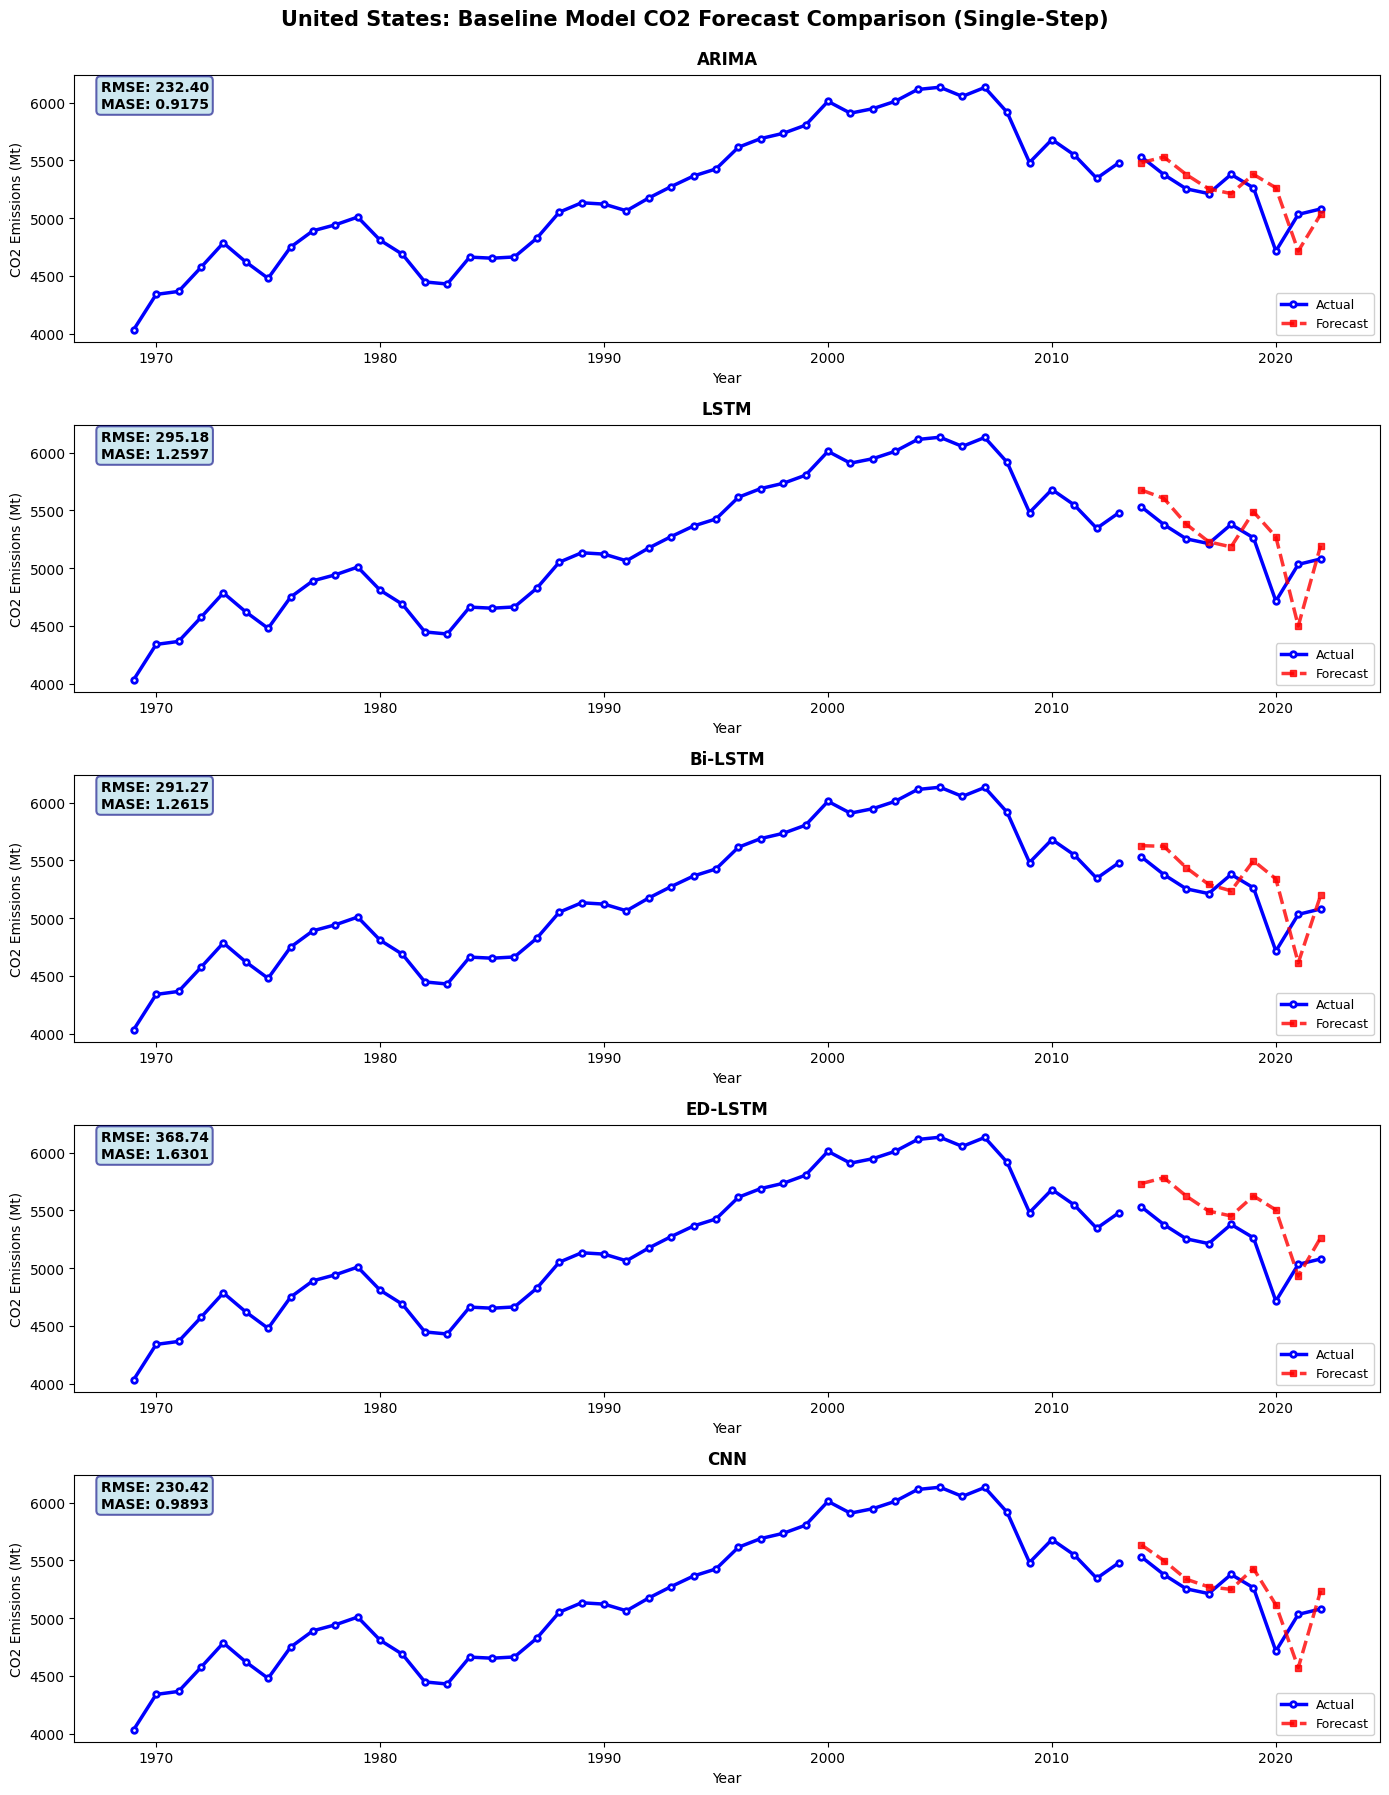

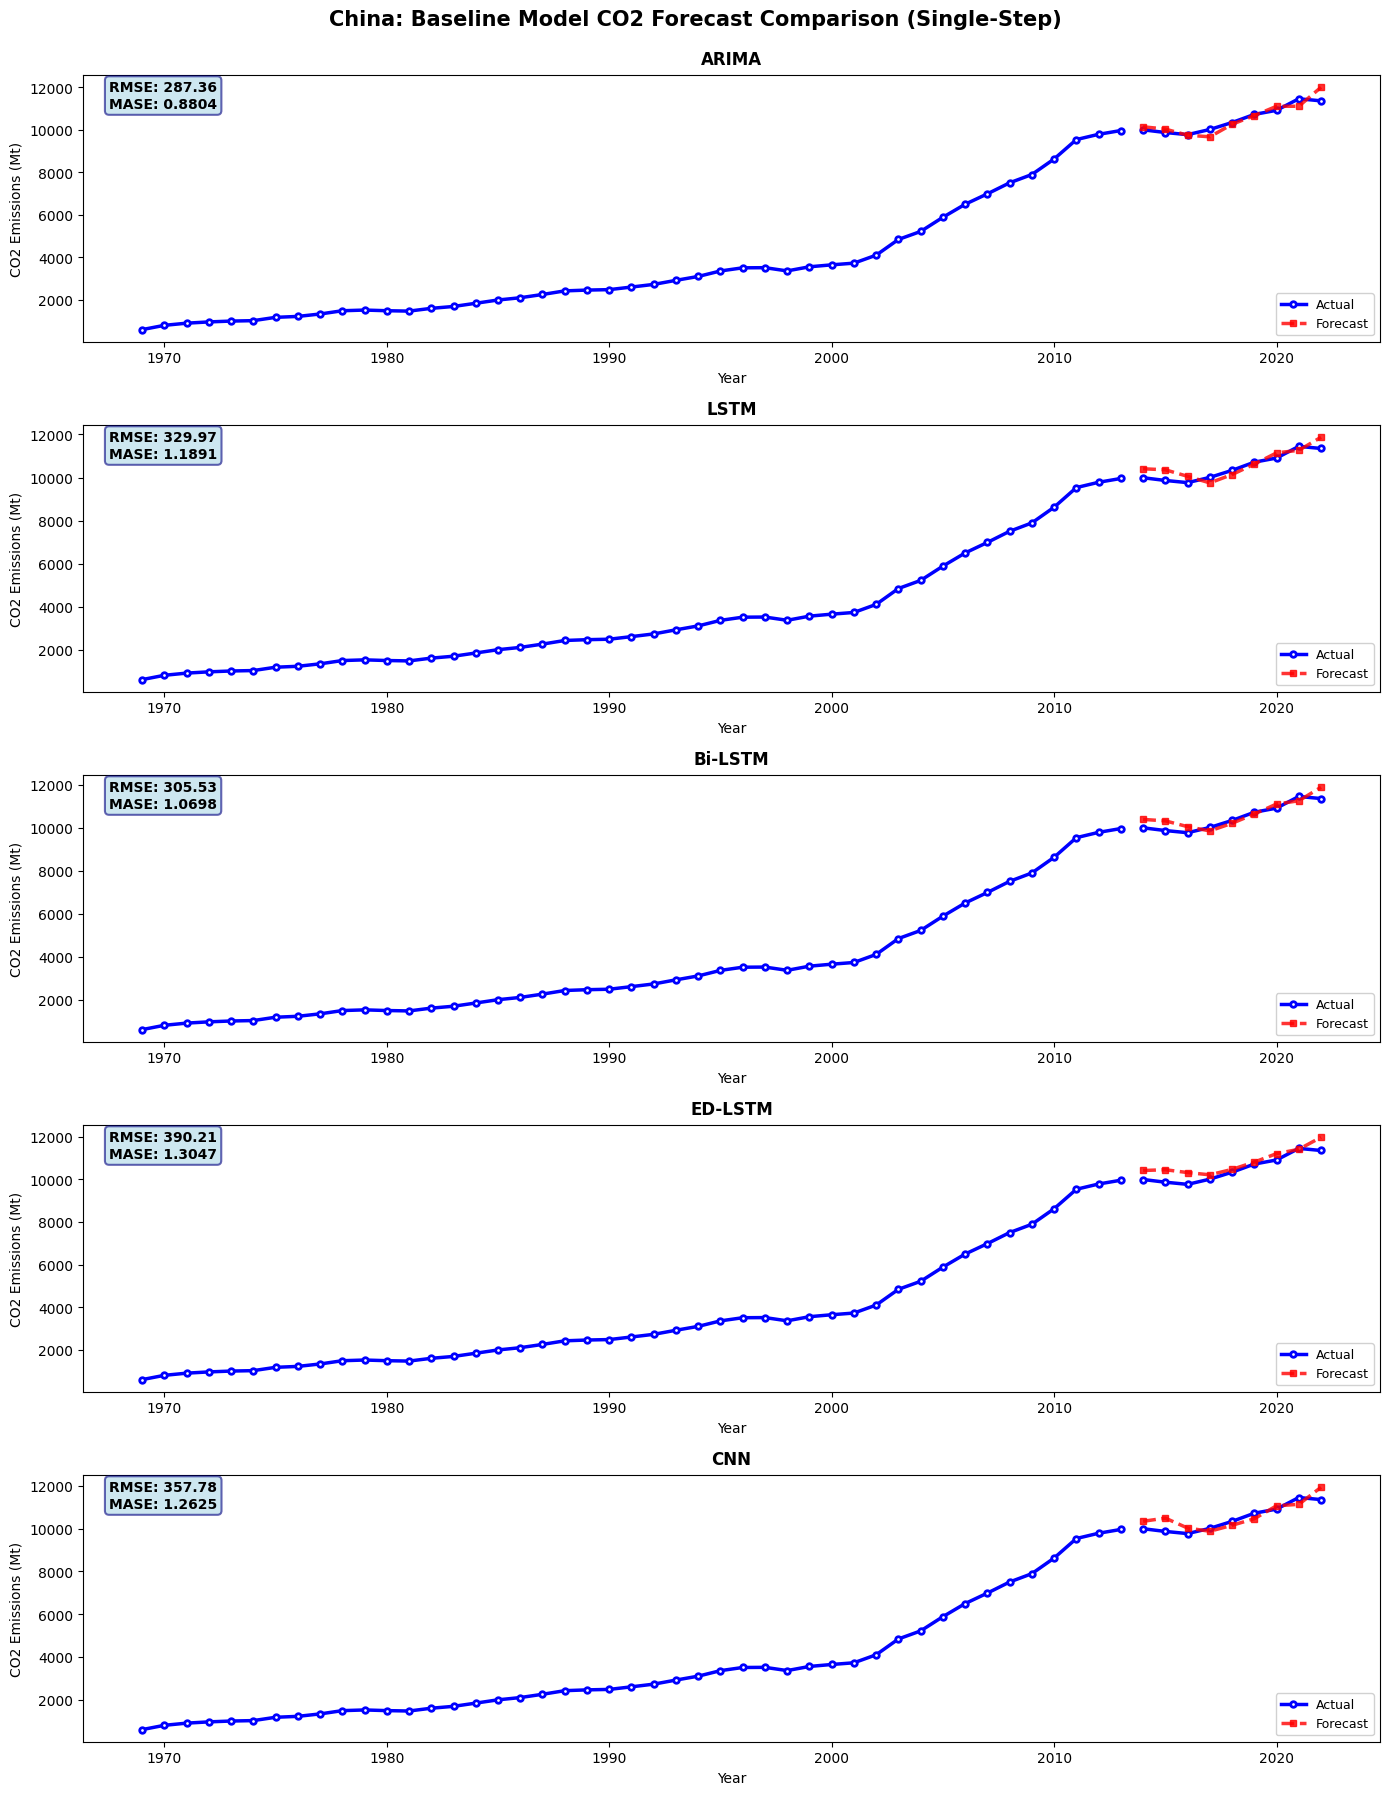

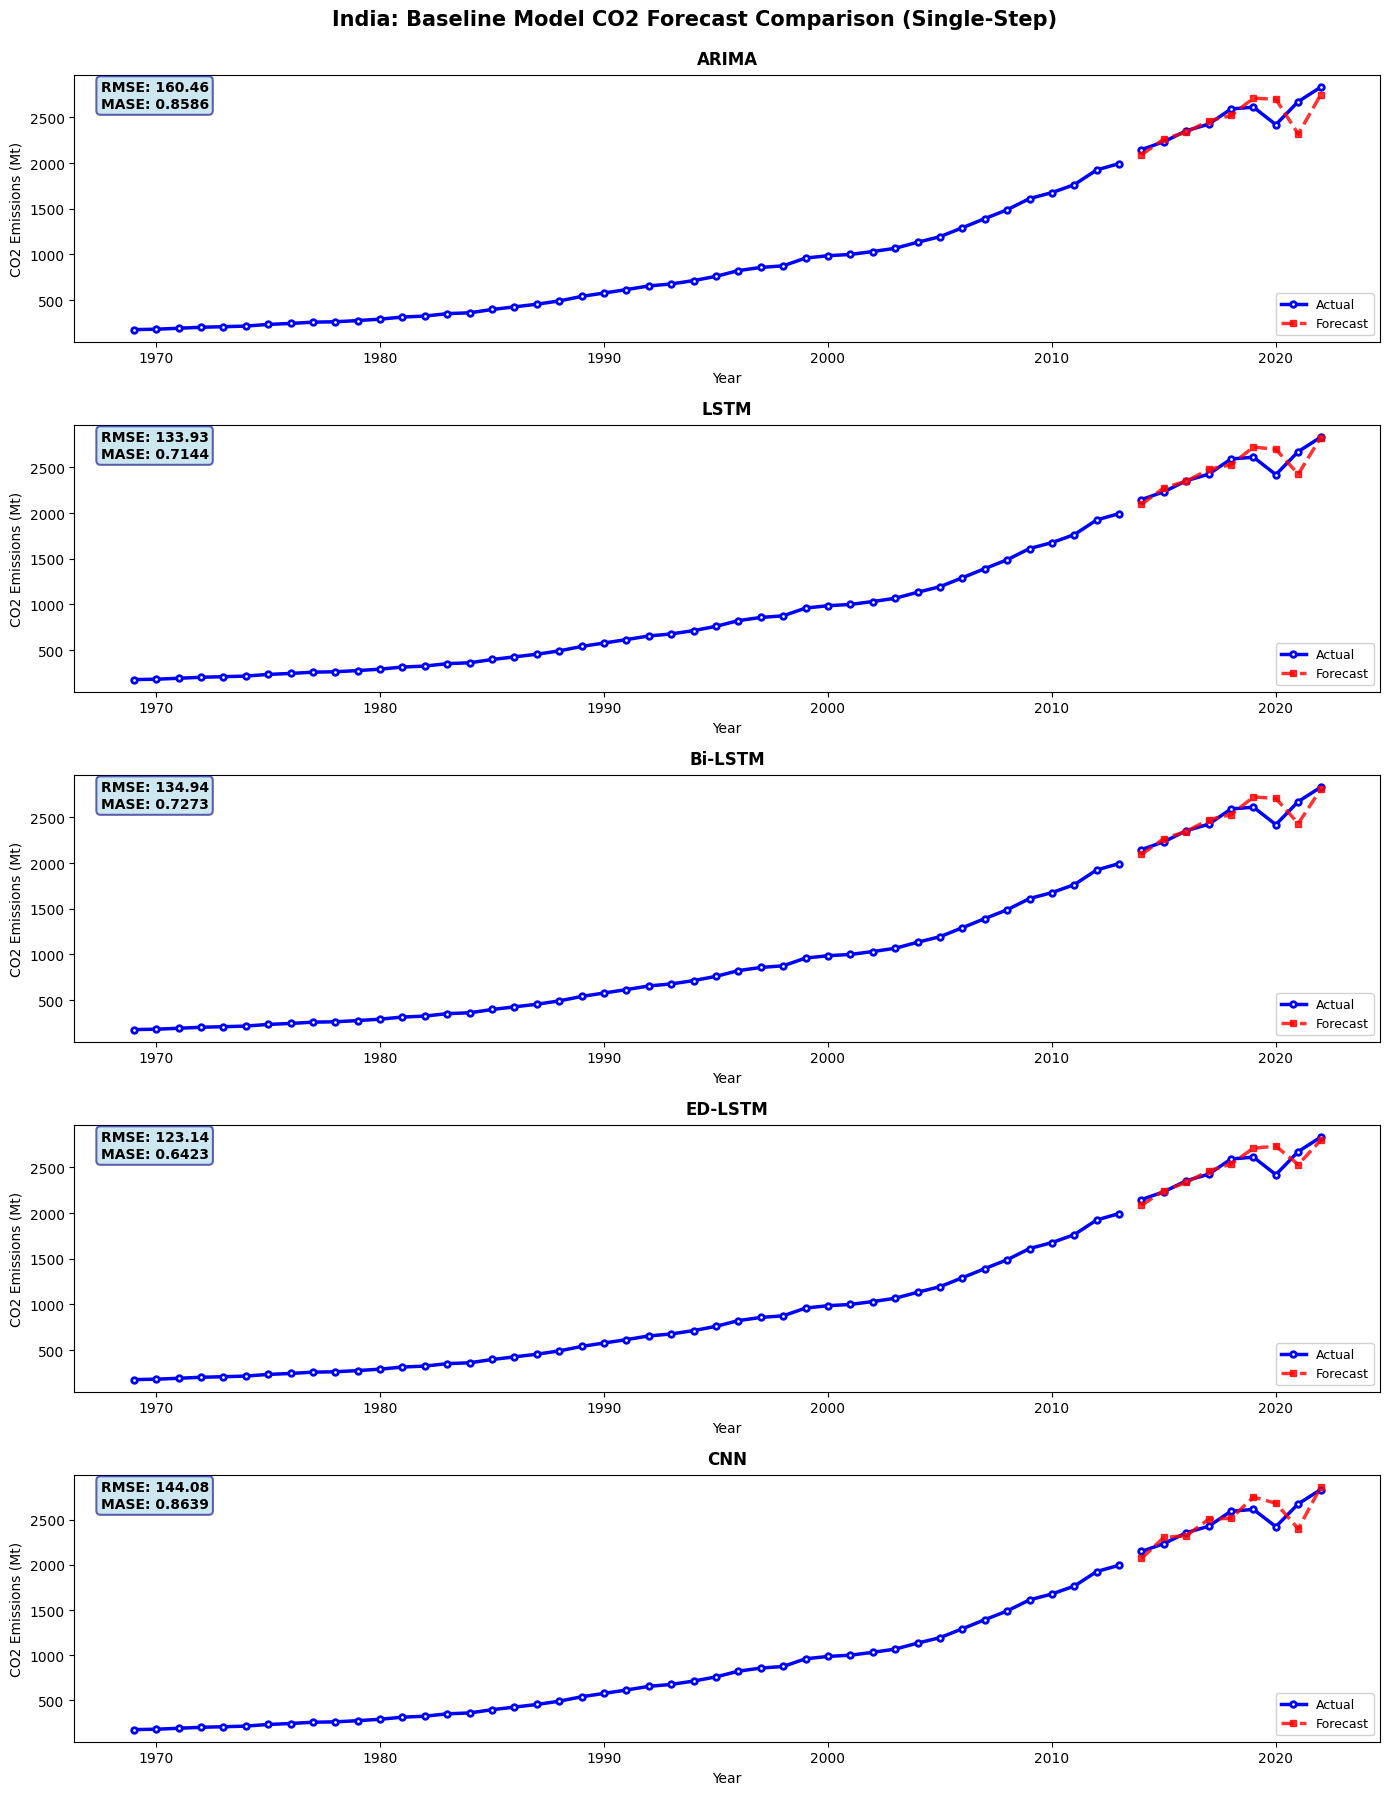

In [131]:
colors = {'actual': 'blue', 'forecast': 'red'}
models_to_plot = ['ARIMA', 'LSTM', 'Bi-LSTM', 'ED-LSTM', 'CNN']

for country in SELECTED_COUNTRIES:
    print(f"\nCreating plot for {country.upper()}")
    
    train_country = train_3_df[train_3_df['country'] == country].sort_values('year')
    test_country = test_3_df[test_3_df['country'] == country].sort_values('year')
    
    fig, axes = plt.subplots(5, 1, figsize=(14, 18))
    
    for idx, model_name in enumerate(models_to_plot):
        ax = axes[idx]
        
        ax.plot(train_country['year'], train_country[TARGET_VARIABLES], 
                color=colors['actual'], linewidth=2.5, label='Actual', 
                marker='o', markersize=4, markerfacecolor='white',
                markeredgewidth=2, markeredgecolor=colors['actual'])
        
        ax.plot(test_country['year'], test_country[TARGET_VARIABLES], 
                color=colors['actual'], linewidth=2.5, 
                marker='o', markersize=4, markerfacecolor='white',
                markeredgewidth=2, markeredgecolor=colors['actual'])
        
        if model_name in all_results[country]:
            result = all_results[country][model_name]
            forecast = result['forecast']
            rmse = result['RMSE']
            mase_score = result['MASE']
            
            ax.plot(test_country['year'], forecast,
                   color=colors['forecast'], linewidth=2.5, linestyle='--',
                   label='Forecast', marker='s', markersize=4, alpha=0.8)
            
            textstr = f"RMSE: {rmse:.2f}\nMASE: {mase_score:.4f}"
            props = dict(boxstyle='round', facecolor='lightblue', alpha=0.6, edgecolor='navy', linewidth=1.5)
            ax.text(0.02, 0.98, textstr, transform=ax.transAxes, fontsize=10,
                   verticalalignment='top', bbox=props, fontweight='bold')
        
        ax.set_title(f'{model_name}', fontsize=12, fontweight='bold', pad=8)
        ax.set_xlabel('Year', fontsize=10)
        ax.set_ylabel('CO2 Emissions (Mt)', fontsize=10)
        ax.legend(loc='lower right', fontsize=9, framealpha=0.9)
    
    plt.suptitle(f'{country}: Baseline Model CO2 Forecast Comparison (Single-Step)', 
                fontsize=15, fontweight='bold', y=0.995)
    plt.tight_layout()
    
    # Save plot
    plot_filename = f"{country.replace(' ', '_')}_baseline_model_comparison.png"
    plot_filepath = os.path.join(save_dir, plot_filename)
    plt.savefig(plot_filepath, dpi=150, bbox_inches='tight')